In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [4]:
# build the dataset

# block_size = 3
# X, Y = [], []

# for w in words:
#     context = [0] * block_size
#     for ch in w + '.':
#         ix = stoi[ch]
#         X.append(context)
#         Y.append(ix)
#         print(''.join(itos[i] for i in context), '--------->', itos[ix])
#         context = context[1:] + [ix]  # crop and append

# X = torch.tensor(X)
# Y = torch.tensor(Y)

def build_dataset(words):
    block_size = 3  # context length
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [5]:
# cleaning up a bit

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)  # total # of parameters

11897

In [6]:
for p in parameters:
    p.requires_grad = True

In [7]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [8]:
lri = []
lossi = []
stepi = []

In [13]:
for i in range(50000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # type: ignore

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])  # type: ignore
    # print(loss.item())

    # cross_entropy is simpler & more efficient
    # also more numerically well-behaved with very large logits since exp() can go to inf

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad # type: ignore

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())


2.281848907470703


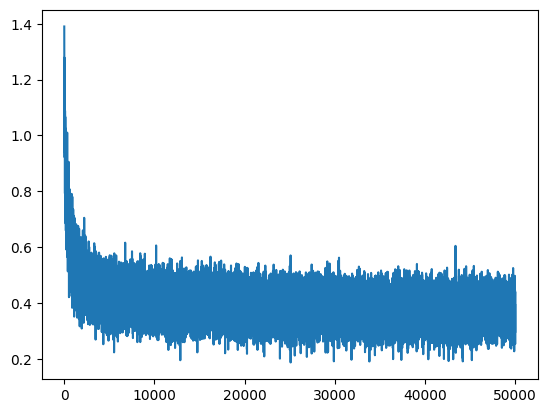

In [10]:
plt.plot(stepi, lossi)

In [14]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2121, grad_fn=<NllLossBackward0>)

In [17]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * 3
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

deynn.
jamereton.
kylon.
sabell.
tat.
eidhan.
kaly.
eag.
ron.
jiks.
taia.
azyrvis.
addyr.
lyonce.
yothiyah.
jafei.
layna.
ez.
camilaysi.
yaezberlsa.
